In [1]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm
import datetime
import pandas as pd

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib
theano.config.optimizer='fast_run'
theano.config.floatX = "float64"

# Legend-formating for matplotlib
def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner

In [5]:
def plain_SIR_model(beta,gamma,N,S0,I0,R0,l=150):
    """Simple classical SIR-Model with time-constant beta,gamma"""
    def next_day(t,St,It,Rt,oS,oI,oR,eff,beta,gamma,N):
        eff = beta*St/N
        bSIoN = eff * It # -beta * (S*I)/N
        gI = gamma*It
        # Calculate differences
        dS = -bSIoN
        dI = bSIoN - gI
        dR = gI
        # Update values
        nxt_St = St + dS
        nxt_It = It + dI
        nxt_Rt = Rt + dR
        
        nxt_St = tt.clip(nxt_St,0,1e16) # Improves sampling stability
        
        # Pass on to next step
        return nxt_St,nxt_It,nxt_Rt, dS,dI,dR, eff
        
    # Initial internal state
    zero = tt.cast(0.,dtype='float64')
    initial_state = [S0,I0,R0,zero,zero,zero,zero]
    sequences = [tt.arange(l)]
    # Exceute the 'Loop'
    state,_ = theano.scan(fn=next_day,
                            sequences=sequences,# time dependent sequences can be passed as first params
                            outputs_info=initial_state,
                            non_sequences=[beta,gamma,N])
    return state


def Gompertz(a,b,c,l=150):
    t = tt.arange(l)
    return a*tt.exp(-b*tt.exp(-c*t))

In [3]:
with open("estimates/sir_1598863829","rb") as f:
    sir_est = pickle.load(f)
    
with open("estimates/gomp_1598863829","rb") as f:
    sir_est = pickle.load(f)

In [24]:
# Transpose the Dataset
b,g,n,i0 = tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64")
i = tt.scalar(dtype="int64")
z = tt.constant(0.,dtype='float64')
S_t,I_t,R_t,dS,dI,dR,eff = plain_SIR_model(b,g,n,n,i0,z,i)
sat_f = theano.function(inputs=[b,g,n,i0,i],outputs=R_t[-1])


estimation_series = {}
for k,v in sir_est.items():
    if "ssd" not in estimation_series.keys():
        estimation_series["ssd"] = []
    estimation_series["ssd"].append(v["ssd"])
    for p in ['beta','gamma','N','I0']:
        if p not in estimation_series.keys():
            estimation_series[p] = {"mu":[],2.5:[],5:[],50:[],95:[],97.5:[]} 
        es = estimation_series[p]
        es["mu"].append(np.mean(v[p]))
        q = np.percentile(v[p],q=(2.5,5,50,95,97.5))
        es[2.5].append(q[0])
        es[5].append(q[1])
        es[50].append(q[2])
        es[95].append(q[3])
        es[97.5].append(q[4])
        
    sat = []
    for i,beta,gamma,N,I0 in zip(range(len(v["beta"])),v["beta"],v["gamma"],v["N"],v["I0"]):
        sat.append( sat_f(beta,gamma,N,I0,300) )
    
    if "saturation" not in estimation_series.keys():
        estimation_series["saturation"] = {"mu":[],2.5:[],5:[],50:[],95:[],97.5:[]} 
    es = estimation_series["saturation"]
    sata = np.array(sat)
    q = np.percentile(sata,q=(2.5,5,50,95,97.5))
    es["mu"].append(np.mean(sata))
    es[2.5].append(q[0])
    es[5].append(q[1])
    es[50].append(q[2])
    es[95].append(q[3])
    es[97.5].append(q[4])
    
    print(k,v["ssd"],np.mean(v["N"]),np.mean(sata))

sir_est_series = estimation_series


30 5193.81726622813 3675.783610837497 3481.8930560591252
31 45492.52227784255 3754.9884870517426 3539.0286828806584
32 104791.99416125035 3958.0644823696202 3776.9070896826856
33 53090.62779556868 4594.094443542365 4314.838149634354
34 77126.22334032677 4353.2106353505515 4127.466322458841
35 68969.28688006375 4500.255917035483 4243.091120785803
36 68334.78421614469 4638.407116006251 4415.458759513172
37 68827.85953817064 4624.295879061551 4389.600409121098
38 206911.5227510138 4692.12314047313 4477.712759831775
39 417185.8980507086 4785.139788568737 4589.868952584112
40 731615.3746867869 4949.175694413824 4786.134475692251
41 670222.5329031548 5368.682599770329 5192.76266227214
42 487695.62689404225 6029.907973192481 5902.481450479009
43 527686.6985269674 6357.966662227396 6246.65132845198
44 561578.8243512072 6605.453560491016 6524.06412715201
45 565462.5361928405 7289.348817782936 7255.036789015063
46 723799.2995027662 7238.016863666217 7199.652915120858
47 850814.4054817623 7404.37

In [ ]:
# Transpose the Dataset
a,b,c = tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64")
i = tt.scalar(dtype="int64")
r = Gompertz(a,b,c,i)
sat_f = theano.function(inputs=[a,b,c,i],outputs=r[-1])


estimation_series = {}
for k,v in sir_est.items():
    if "ssd" not in estimation_series.keys():
        estimation_series["ssd"] = []
    estimation_series["ssd"].append(v["ssd"])
    for p in ['beta','gamma','N','I0']:
        if p not in estimation_series.keys():
            estimation_series[p] = {"mu":[],2.5:[],5:[],50:[],95:[],97.5:[]} 
        es = estimation_series[p]
        es["mu"].append(np.mean(v[p]))
        q = np.percentile(v[p],q=(2.5,5,50,95,97.5))
        es[2.5].append(q[0])
        es[5].append(q[1])
        es[50].append(q[2])
        es[95].append(q[3])
        es[97.5].append(q[4])
        
    sat = []
    for i,beta,gamma,N,I0 in zip(range(len(v["beta"])),v["beta"],v["gamma"],v["N"],v["I0"]):
        sat.append( sat_f(beta,gamma,N,I0,300) )
    
    if "saturation" not in estimation_series.keys():
        estimation_series["saturation"] = {"mu":[],2.5:[],5:[],50:[],95:[],97.5:[]} 
    es = estimation_series["saturation"]
    sata = np.array(sat)
    q = np.percentile(sata,q=(2.5,5,50,95,97.5))
    es["mu"].append(np.mean(sata))
    es[2.5].append(q[0])
    es[5].append(q[1])
    es[50].append(q[2])
    es[95].append(q[3])
    es[97.5].append(q[4])
    
    print(k,v["ssd"],np.mean(v["N"]),np.mean(sata))

gomp_est_series = estimation_series

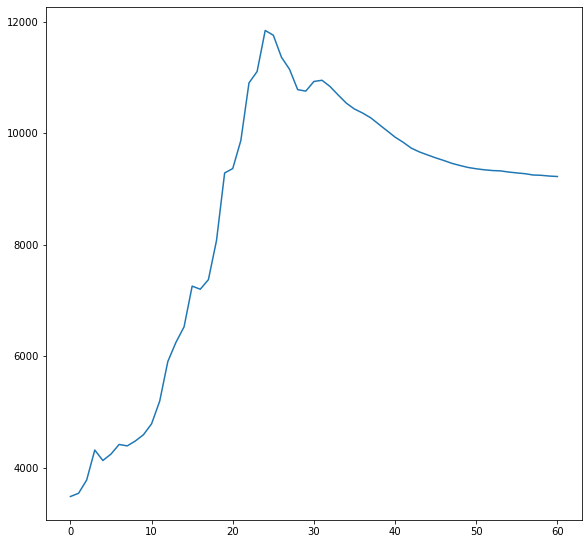

In [30]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.05,right=0.98,top=0.94,bottom=0.05)

gs = fig.add_gridspec(1, 1)


ax = fig.add_subplot(gs[0,0])
ax.plot(sir_est_series["saturation"]["mu"])